## Import necessary libraries

In [1]:
%matplotlib inline

In [16]:
import matplotlib.pyplot as plt
import matplotlib
import ndreg
from ndreg import preprocessor, util, plotter
import SimpleITK as sitk

In [3]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [4]:
def myshow(img, cmap='gray', colorbar=False):
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=cmap)
    if colorbar: plt.colorbar()
    plt.axis('off')
    plt.show()

### Some metadata is required before registration

In [5]:
params = {
    # input image path
    'image_path': '/work/ndreg/Thy1eYFP_Control_9.tiff',
    # voxel spacing is in mm and corresponds to (x, y, z) spacing
    'image_spacing': (0.04128, 0.04128, 0.04128),
    'image_orientation': 'rpi',
    # the modality can be 'lavision' or 'colm'
    'image_modality': 'lavision',
    'atlas_spacing': (0.05, 0.05, 0.05),
    'atlas_path': '/work/ndreg/ARA_50um.tiff',
}

## Load the sample data

In [6]:
img = util.imgRead(params['image_path'])
img.SetSpacing(params['image_spacing'])
atlas = util.imgRead(params['atlas_path'])
atlas.SetSpacing(params['atlas_spacing'])

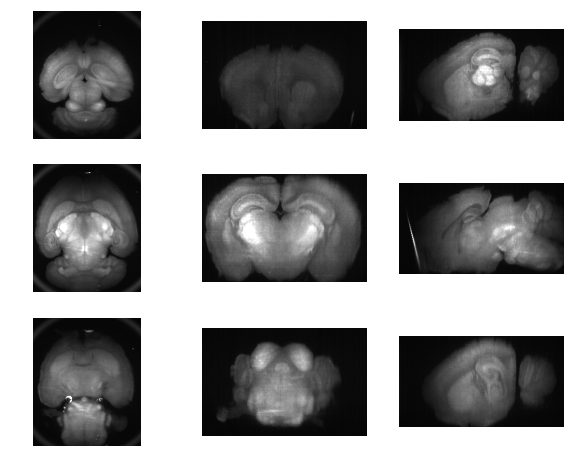

In [7]:
plotter.imgShow(img, vmax=2000)

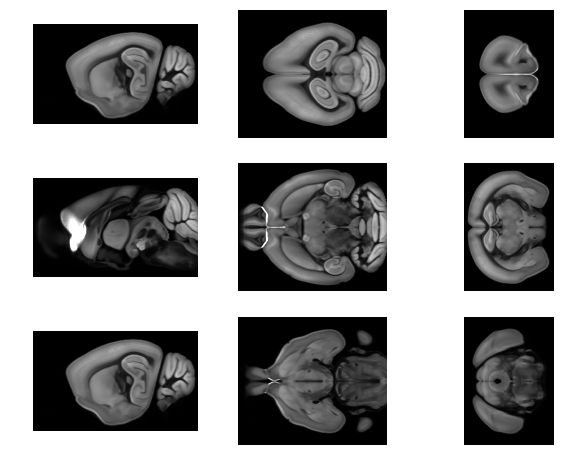

In [8]:
plotter.imgShow(atlas, vmax=400)

## Preprocessing
This step preprocesses the input CLARITY images by resampling them to match the resolution of the atlas, bias correcting the images, and normalizing them by subtracting the mean and dividing by the standard deviation of the image intensities.

In [9]:
img_p = preprocessor.preprocess_brain(img, 
                                      params['atlas_spacing'], 
                                      params['image_modality'],
                                      params['image_orientation'])

## Registration
We want to obtain the parameters to transform the original image to the new image. The transformation from the original image to the new image can be described as a composition of an affine transformation which can perform a combination of translation, scaling, rotation, and shear and deformable registration called LDDMM.

The output of this method is the atlas registered to the raw data

In [12]:
atlas_registered = ndreg.register_brain(atlas, img_p)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	85211.2, 89.4791, 0, 85121.7 (96.8504%), 2.750000e-03
1.	80645.1, 88.5653, 0, 80556.6 (91.6562%), 1.512500e-03
2.	74649.1, 124.356, 0, 74524.8 (84.7933%), 1.663750e-03
3.	72169.8, 157.397, 0, 72012.4 (81.9348%), 1.830125e-03
4.	70108.4, 214.212, 0, 69894.2 (79.5246%), 2.013138e-03
5.	68309.3, 280.522, 0, 68028.7 (77.4022%), 2.214451e-03
6.	67787.6, 327.251, 0, 67460.4 (76.7555%), 1.217948e-03
7.	66422.6, 376.188, 0, 66046.4 (75.1467%), 1.339743e-03
8.	66152.8, 440.439, 0, 65712.4 (74.7667%), 1.473717e-03
9.	65167.4, 511.05, 0, 64656.4 (73.5651%), 1.621089e-03
10.	64353.4, 553.485, 0, 63799.9 (72.5907%), 8.915990e-04
11.	62982.5, 600.129, 0, 62382.4 (70.9779%), 9.807589e-04
12.	62903.5, 654.72, 0, 62248.7 (70.8258%), 1.078835e-03
13.	62119.7, 719.976, 0, 61399.7 (69.8597%), 1.186718e-03
14.	61991.5, 788.65, 0, 61202.9 (69.6358%), 1.305390e-03
15.	60786.9, 829.161, 0, 59957.7 (68.219


Step 4: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	55244.2, 1.76524, 0, 55242.5 (94.6864%), 1.375000e-03
1.	55014.5, 0.819608, 0, 55013.6 (94.2942%), 3.781250e-04
E = 55014.5 (94.2942%)
Length = 2.21175
Time = 193.536s (3.22561m)


## Visualize registered image

The two images below should match if the registration worked successfully!

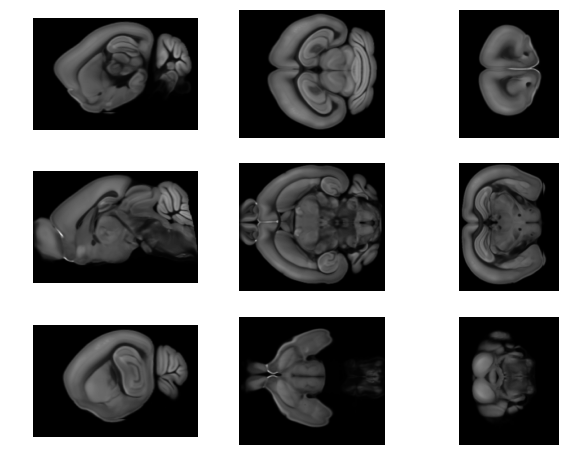

In [13]:
plotter.imgShow(atlas_registered)

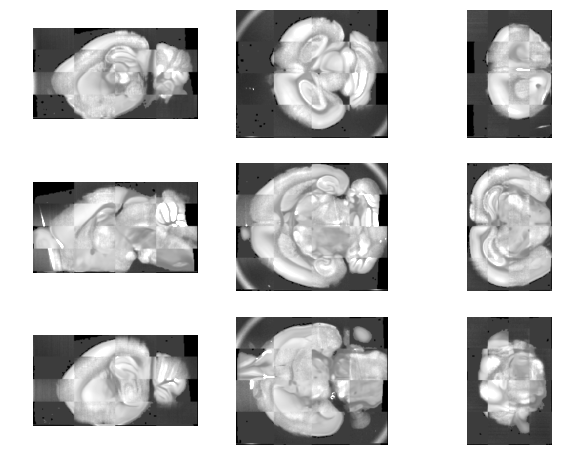

In [14]:
plotter.imgShow(plotter.imgChecker(atlas_registered, img_p), vmax=500)

# Quantitative evaluation

Here, we print out the Mean Squared Error between both the atlas and the observed data. As we can see, this metric decreases from the unprocessed data (first cell below this one) to the final atlas registered to our data (3rd cell below this one)

In [17]:
ndreg.imgMSE(sitk.Normalize(atlas), sitk.Normalize(img))

1.9355552516414318

In [18]:
ndreg.imgMSE(sitk.Normalize(atlas), sitk.Normalize(img_p))

0.7295863343635678

In [19]:
ndreg.imgMSE(sitk.Normalize(atlas_registered), sitk.Normalize(img_p))

0.4168717700464365